# CNN for Brain Tumor Classifications in MRIs

In this project, a Convolutional Neural Network (CNN) is created to perform classification between 4 different classes of brain tumors through their MRI images: gliomas, meningiomas, pituitary and no-tumors. We've used 5,712 images to train the model and  1,311 images to later test it. 

The model roughly had an accuracy of 93% on its first iteration and classified the no-tumor MRI scans the best.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [2]:
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 5

#### Loading Data into Training/Testing Datasets and Preprocessing Images for Scaling & Normalization 

In [3]:
train_data_generator = ImageDataGenerator(rescale=1./255)

train_generator = train_data_generator.flow_from_directory(
        r'C:\Users\muham\Desktop\MSc Biomedical Engineering\Deep Learning in Medical Imaging\Homework 3\Training',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')

test_data_generator = ImageDataGenerator(rescale=1./255)

test_generator = test_data_generator.flow_from_directory(
        r'C:\Users\muham\Desktop\MSc Biomedical Engineering\Deep Learning in Medical Imaging\Homework 3\Testing',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [4]:
print(train_generator.class_indices)
print(test_generator.class_indices)

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


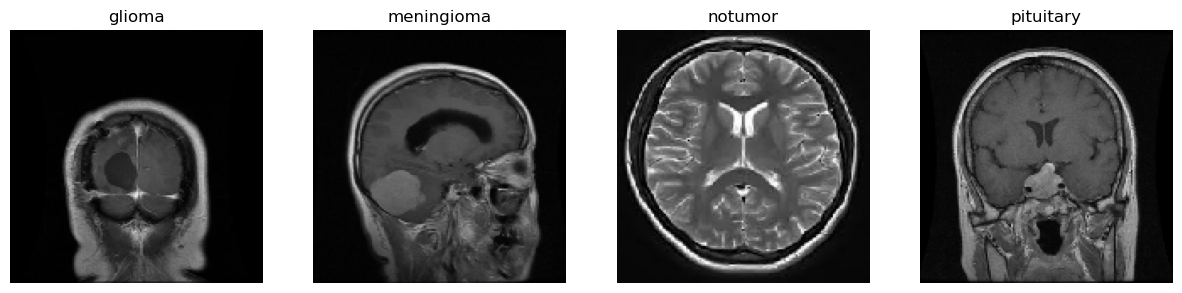

In [5]:
# Show sample images from each class
import matplotlib.pyplot as plt
batch = next(train_generator)

class_indices = train_generator.class_indices
class_idx_to_sample = {}
for class_name, class_idx in class_indices.items():
    class_idx_to_sample[class_idx] = [i for i, label in enumerate(batch[1]) if label[class_idx] == 1][0]

fig, axs = plt.subplots(1, len(class_indices), figsize=(15, 5))
for class_idx, ax in zip(range(len(class_indices)), axs):
    image = batch[0][class_idx_to_sample[class_idx]]
    class_name = list(class_indices.keys())[class_idx]
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(class_name)
plt.show()

#### CNN Model with 2 Convolutional Layers & 2 Maxpooling Layers using ReLu Activation 

In [6]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

#### Evaluation Metrics: Cross-entropy Loss Function & Adam Optimizer 

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(
        train_generator,
        steps_per_epoch=train_generator.n // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=test_generator,
        validation_steps=test_generator.n // BATCH_SIZE)

Epoch 1/5
178/178 [==============================] - 68s 380ms/step - loss: 0.6079 - accuracy: 0.7634 - val_loss: 0.4152 - val_accuracy: 0.8516
Epoch 2/5
178/178 [==============================] - 76s 429ms/step - loss: 0.2323 - accuracy: 0.9155 - val_loss: 0.2702 - val_accuracy: 0.8898
Epoch 3/5
178/178 [==============================] - 77s 434ms/step - loss: 0.1121 - accuracy: 0.9600 - val_loss: 0.1651 - val_accuracy: 0.9414
Epoch 4/5
178/178 [==============================] - 78s 439ms/step - loss: 0.0445 - accuracy: 0.9880 - val_loss: 0.1506 - val_accuracy: 0.9594
Epoch 5/5
178/178 [==============================] - 77s 433ms/step - loss: 0.0217 - accuracy: 0.9951 - val_loss: 0.1752 - val_accuracy: 0.9563


#### Accuracy Measure, Confusion Matrix & Classification Report

In [8]:
# Evaluate model on test data
loss, accuracy = model.evaluate(test_generator)

# Print accuracy
print('Accuracy on Test Data:', accuracy)

41/41 [==============================] - 5s 119ms/step - loss: 0.1718 - accuracy: 0.9573
Accuracy on Test Data: 0.9572845101356506


In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Generate predicted labels for test data
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Generate true labels for test data
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred)

print(cm)
print(cr)

41/41 [==============================] - 5s 114ms/step
[[ 68  73  84  75]
 [ 66  69 101  70]
 [ 85  86 135  99]
 [ 67  80  90  63]]
              precision    recall  f1-score   support

           0       0.24      0.23      0.23       300
           1       0.22      0.23      0.22       306
           2       0.33      0.33      0.33       405
           3       0.21      0.21      0.21       300

    accuracy                           0.26      1311
   macro avg       0.25      0.25      0.25      1311
weighted avg       0.26      0.26      0.26      1311



In [10]:
# Finding class with highest diagonal value in confusion matrix
best_class_cm = np.argmax(np.diagonal(cm))
class_cm = list(test_generator.class_indices.keys())[list(test_generator.class_indices.values()).index(best_class_cm)]
print("Best Classification according to Confusion Matrix: ", class_cm)

# Finding class with highest F1-Score
report_lines = cr.split('\n')
f1_scores = []

for line in report_lines:
    parts = line.split()
    if len(parts) > 1 and parts[0].isdigit():
        f1_score = float(parts[-2])
        f1_scores.append(f1_score)
        
best_class_cr = f1_scores.index(max(f1_scores))
class_cr = list(test_generator.class_indices.keys())[list(test_generator.class_indices.values()).index(best_class_cr)]
print("Class with Highest F1-Score: ", class_cr)

Best Classification according to Confusion Matrix:  notumor
Class with Highest F1-Score:  notumor
